# Importing Libraries and Dependencies

In [1]:
import os
import requests, zipfile, io
import shutil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

# import folium
import requests
from IPython.display import display

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX


import pmdarima as pm
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.vector_ar.var_model import VAR

C:\Users\nihar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Datafile Loading

In [2]:
df_0 = pd.read_csv("PRSA_Data_Aotizhongxin_20130301-20170228.csv")
df_0

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,35063,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


# Exploratory Data Analysis

* Done in a sepearate file

## Data Transformation

* Dropping un-wanted columns

In [3]:
df_0.drop(columns=['No','wd','station'], inplace=True)
df_0

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,2.4
35060,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,0.9
35061,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,1.1
35062,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,1.2


* Transforming `year`, `month`, `day`, and `hour` columns into a new column `timestamp`.
* Setting `timestamp` column as the new index of the datframe.

In [4]:
df_0['timestamp'] = pd.to_datetime(df_0[["year", "month", "day", "hour"]])
df_0 = df_0.sort_values(by="timestamp").reset_index(drop=True)

df_0.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

df_0.set_index(df_0['timestamp'], inplace=True)
df_0.drop(columns = ["timestamp"], axis=0, inplace=True)

df_0

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
timestamp,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,2.4
2017-02-28 20:00:00,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,0.9
2017-02-28 21:00:00,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,1.1


# Models

## Uni-variate Models

### ARIMA and SARIMA

* We will be working on weekly samples, to find underlying trends and patterns inside the data.
* So we will need to resample the data on weekly basis, by calculating the mean of all the observations during that week.

In [5]:
df_1 = df_0.copy()
df_wk = df_1.resample('W').mean()
df_wk

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
timestamp,,,,,,,,,,,
2013-03-03,38.263889,57.791667,36.541667,56.750000,958.236111,37.583333,2.525000,1022.777778,-15.666667,0.000000,2.130556
2013-03-10,139.428571,198.149701,65.280906,97.762964,2021.701220,59.529762,7.797619,1008.958929,-7.088690,0.000000,2.006548
2013-03-17,157.071429,177.184524,57.416667,81.952381,1711.277108,65.720238,6.402976,1014.233929,-2.277976,0.017262,1.599405
2013-03-24,67.321429,92.511905,19.750000,55.160714,1026.663793,38.795785,4.535119,1009.782738,-5.529762,0.098810,2.416667
2013-03-31,107.333333,145.422619,41.559006,72.244048,1286.089041,29.011673,6.991071,1012.829762,-3.762500,0.000000,1.922024
...,...,...,...,...,...,...,...,...,...,...,...
2017-02-05,92.160714,98.678571,32.142857,58.071429,1522.754491,71.196429,0.768304,1024.101984,-18.331548,0.000000,1.704167
2017-02-12,41.227545,56.155689,17.473054,45.095808,895.783133,65.257485,0.625298,1025.392857,-16.977381,0.000000,2.352976
2017-02-19,119.547619,136.089286,28.398810,81.863095,1858.928571,33.077381,2.870238,1019.840476,-11.551190,0.000000,1.970833


* ARIMA is robust enought to handly `NaN` values, so we will have to remove them before feeding the data to the ARIMA and SARIMA model.

In [6]:
df_wk.dropna(inplace=True)

* Spliting the data into `train_wk` and `test_wk`.

In [7]:
split_data = round(len(df_wk) * 0.80)
train_wk, test_wk = df_wk[:split_data], df_wk[split_data:]

PM2.5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1318.303, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1281.508, Time=1.38 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=3.38 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1292.152, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=6.22 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=7.00 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=2.23 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=8.38 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1307.125, Time=1.14 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=1271.524, Time=2.06 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=1286.088, Time=0.41 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=8.35 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=9.31 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=6.76 sec
 ARIMA(2,1,0)(2,1,1)[52]             : AIC=1274.336, 

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

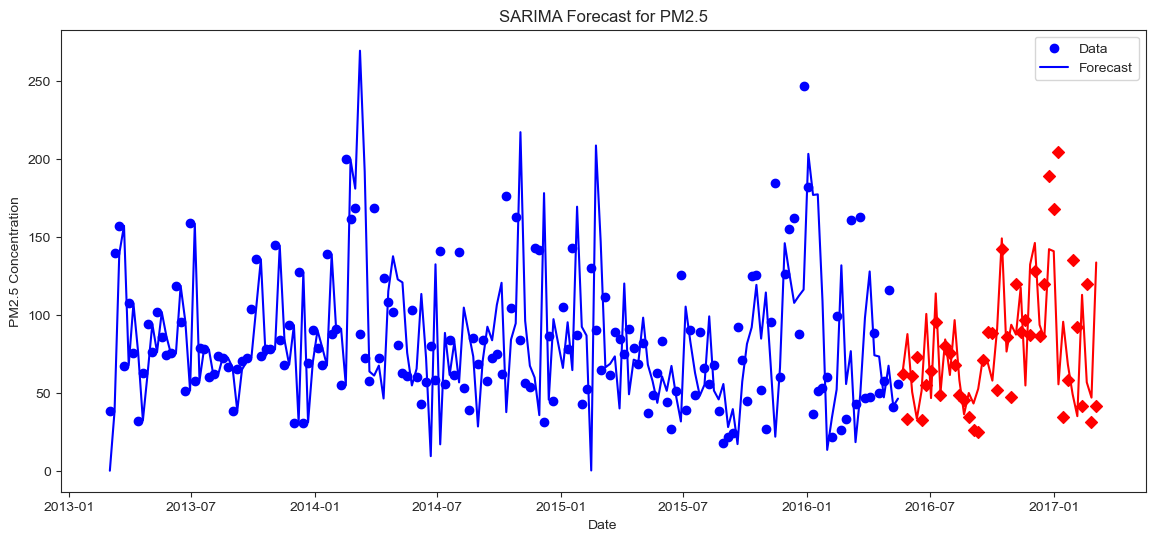

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

PM10
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1335.123, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1302.483, Time=1.42 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=3.89 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1317.983, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=1304.135, Time=5.87 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=1304.134, Time=3.11 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=2.88 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=1306.135, Time=7.72 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1322.822, Time=1.04 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=1287.883, Time=2.10 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=1309.594, Time=0.42 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=1289.814, Time=7.71 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=1289.813, Time=4.43 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=6.52 sec
 ARIMA(2,1,0)(2,1,1)[52]     

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

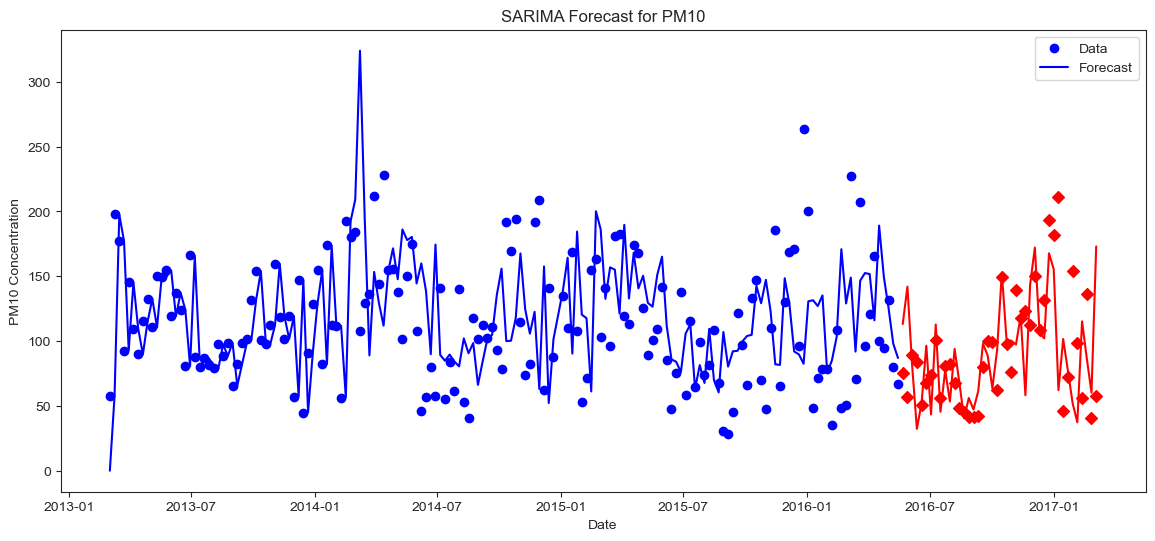

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

SO2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=946.641, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=917.996, Time=1.07 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=887.550, Time=1.68 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=890.980, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=6.76 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=inf, Time=6.69 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=888.083, Time=1.42 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=5.83 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=940.564, Time=1.25 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=889.327, Time=3.66 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=889.197, Time=2.21 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=917.005, Time=1.57 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=890.108, Time=4.05 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=889.516, Time=2.16 sec

Best model:  ARIMA(0,1,1)(0,1,1)[52]    

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

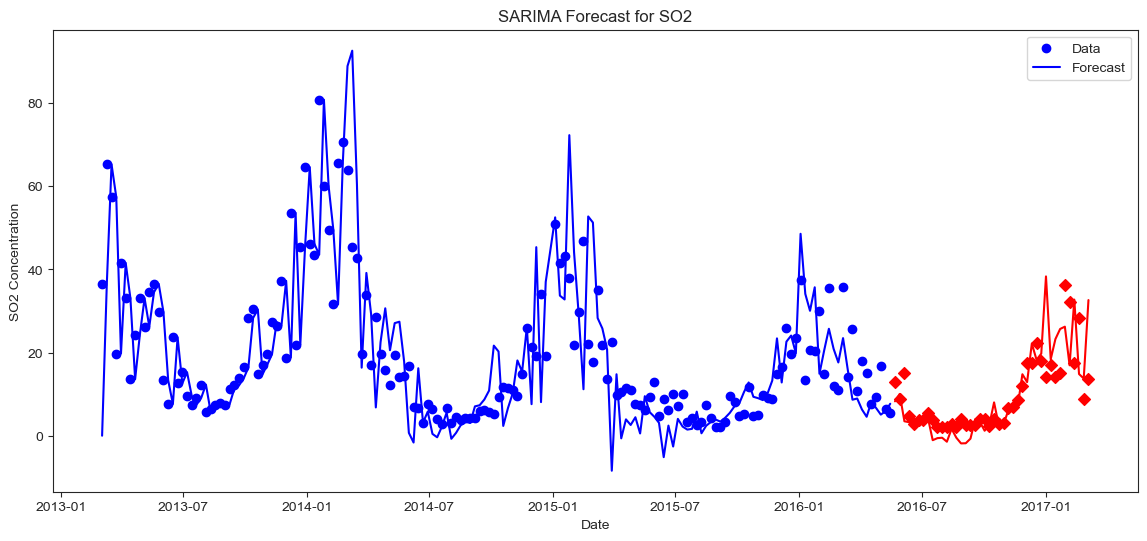

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

NO2
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1079.475, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=3.83 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=2.72 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=1054.599, Time=2.59 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=1056.599, Time=4.99 sec
 ARIMA(0,1,0)(1,1,2)[52]             : AIC=1056.599, Time=4.79 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=inf, Time=11.55 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=3.70 sec
 ARIMA(0,1,0)(2,1,2)[52]             : AIC=inf, Time=7.77 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=1039.988, Time=4.50 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=4.11 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=1041.988, Time=6.79 sec
 ARIMA(1,1,0)(1,1,2)[52]             : AIC=1041.988, T

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

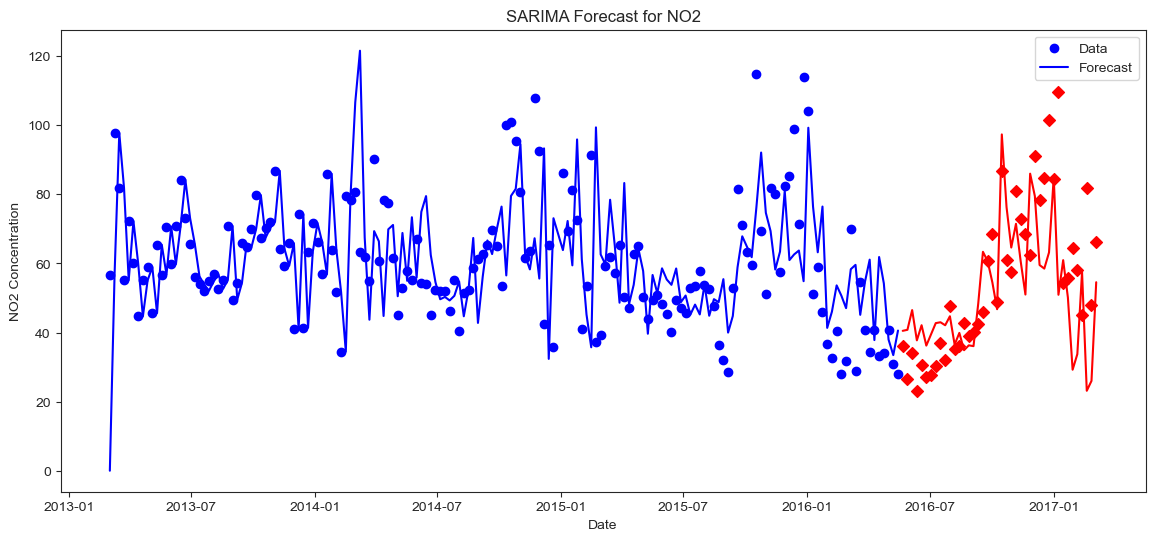

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

CO
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1899.996, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=4.31 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=1.70 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=1862.532, Time=4.99 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=inf, Time=10.31 sec
 ARIMA(0,1,0)(1,1,2)[52]             : AIC=1864.488, Time=16.19 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=inf, Time=13.91 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=1862.493, Time=7.65 sec
 ARIMA(0,1,0)(3,1,0)[52]             : AIC=inf, Time=20.87 sec
 ARIMA(0,1,0)(3,1,1)[52]             : AIC=1866.441, Time=31.34 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=8.70 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1817.139, Time=14.18 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1816.92

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

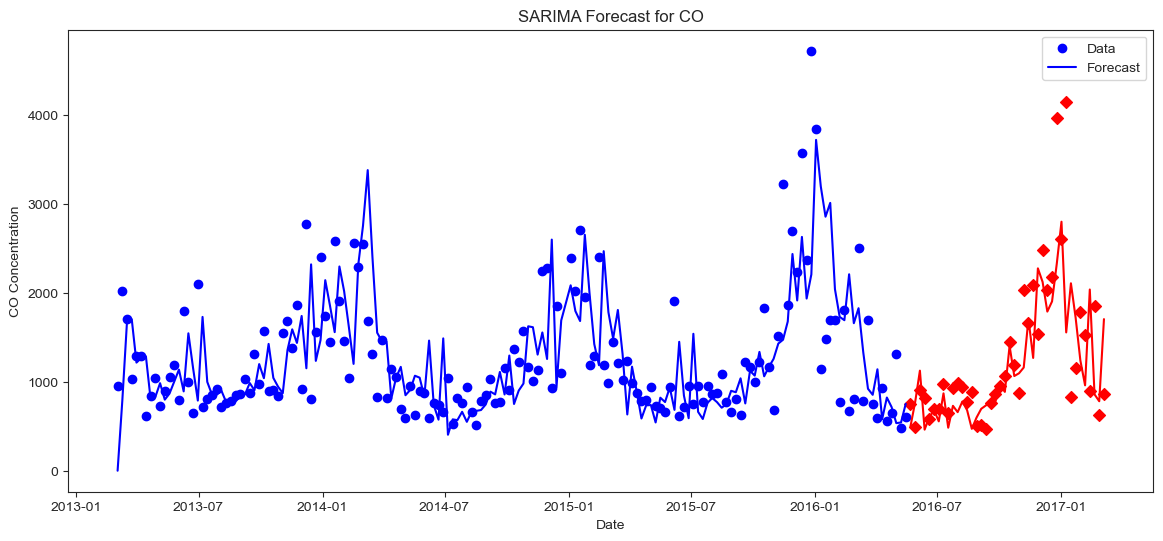

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

O3
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1025.908, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1001.447, Time=1.17 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=972.146, Time=1.75 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=975.170, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=974.028, Time=3.04 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=974.028, Time=5.81 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=972.050, Time=1.35 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=974.028, Time=4.71 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=976.028, Time=6.08 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1020.935, Time=0.83 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=973.590, Time=3.07 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=973.455, Time=2.22 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=975.239, Time=3.20 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=974.007, Time=1.61 sec

Best model:  ARIMA(0,1,1)(

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

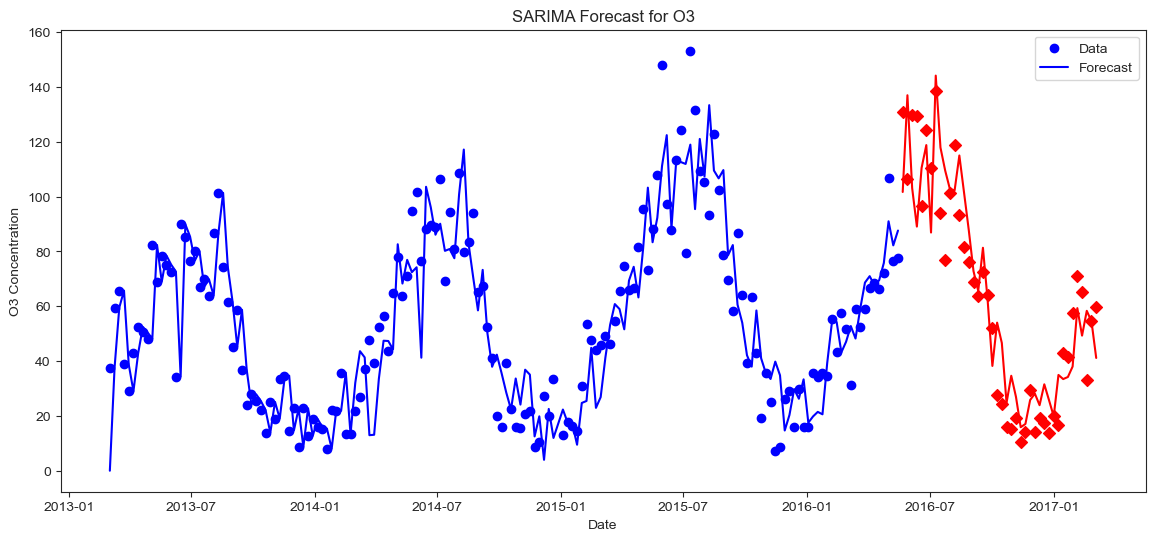

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

In [8]:
# fitting the model
cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3'] # df_wk.columns

sns.set_style('ticks')
mse_table = []

for i in range(len(cols)):
    print(cols[i])
    fit_wk = pm.auto_arima(train_wk[cols[i]], start_p=0, d=1, start_q=0, max_p=2, max_d=2, max_q=2, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, seasonal=True, m=52, trace=True,
                            stepwise=True, njobs=-1)

    plt.figure(figsize=(14, 6))
    plt.scatter(train_wk.index, train_wk[cols[i]], color='blue', marker='o')
    plt.plot(train_wk.index, fit_wk.predict_in_sample(), color='blue')
    
    fit_test, ci_test = fit_wk.predict(n_periods=test_wk.shape[0], return_conf_int=True)
    plt.scatter(test_wk.index, test_wk[cols[i]], color='red', marker='D')
    plt.plot(test_wk.index, fit_wk.predict(n_periods=test_wk.shape[0]), color='red', linestyle='-')
    
    plt.title(f'SARIMA Forecast for {cols[i]}')
    plt.xlabel('Date')
    plt.ylabel(f'{cols[i]} Concentration')
    plt.legend(('Data', 'Forecast'))
    plt.show()

    train_mae = mean_absolute_error(train_wk[cols[i]], fit_wk.predict_in_sample())
    test_mae = mean_absolute_error(test_wk[cols[i]], fit_wk.predict(n_periods=test_wk.shape[0]))

    train_mse = mean_squared_error(train_wk[cols[i]], fit_wk.predict_in_sample())
    test_mse = mean_squared_error(test_wk[cols[i]], fit_wk.predict(n_periods=test_wk.shape[0]))

    train_rmse = root_mean_squared_error(train_wk[cols[i]], fit_wk.predict_in_sample())
    test_rmse = root_mean_squared_error(test_wk[cols[i]], fit_wk.predict(n_periods=test_wk.shape[0]))

    str_to_append = str(cols[i])+" MAE:"+str(test_mae)+" MSE:"+str(test_mse)+" RMSE:"+str(test_rmse)
    mse_table.append(str_to_append)

In [9]:
mse_table

['PM2.5 MAE:32.68477832148651 MSE:1902.8104342744718 RMSE:43.62121541491562',
 'PM10 MAE:32.7954062423103 MSE:2095.0617091382856 RMSE:45.7718440653016',
 'SO2 MAE:4.906476690937301 MSE:54.71739724965993 RMSE:7.39712087569616',
 'NO2 MAE:14.176363631905055 MSE:371.2433070204517 RMSE:19.26767518463117',
 'CO MAE:425.5045811103782 MSE:434612.5424305777 RMSE:659.2515016521219',
 'O3 MAE:14.290247855922185 MSE:301.19629690227754 RMSE:17.355007833541233']

### Prophet

* Has been done in other File

## Multi-variate Models

### Multi-Layer Perceptron (MLP)

In [10]:
data = df_0.copy()
data.dropna(inplace=True)

In [11]:
train_size = int(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]

X_train = train_data[['TEMP','PRES','DEWP','RAIN','WSPM']]
y_train = train_data[['PM2.5','PM10', 'SO2','NO2','CO','O3']]
X_test = test_data[['TEMP','PRES','DEWP','RAIN','WSPM']]
y_test = test_data[['PM2.5','PM10', 'SO2','NO2','CO','O3']]

In [12]:
regr = MLPRegressor(hidden_layer_sizes=(550,500,200,150,50), max_iter=1000) # 50, 100, 150,50
regr.fit(X_train, y_train)
print(regr.n_iter_)

38


In [13]:
preds = regr.predict(X_test)

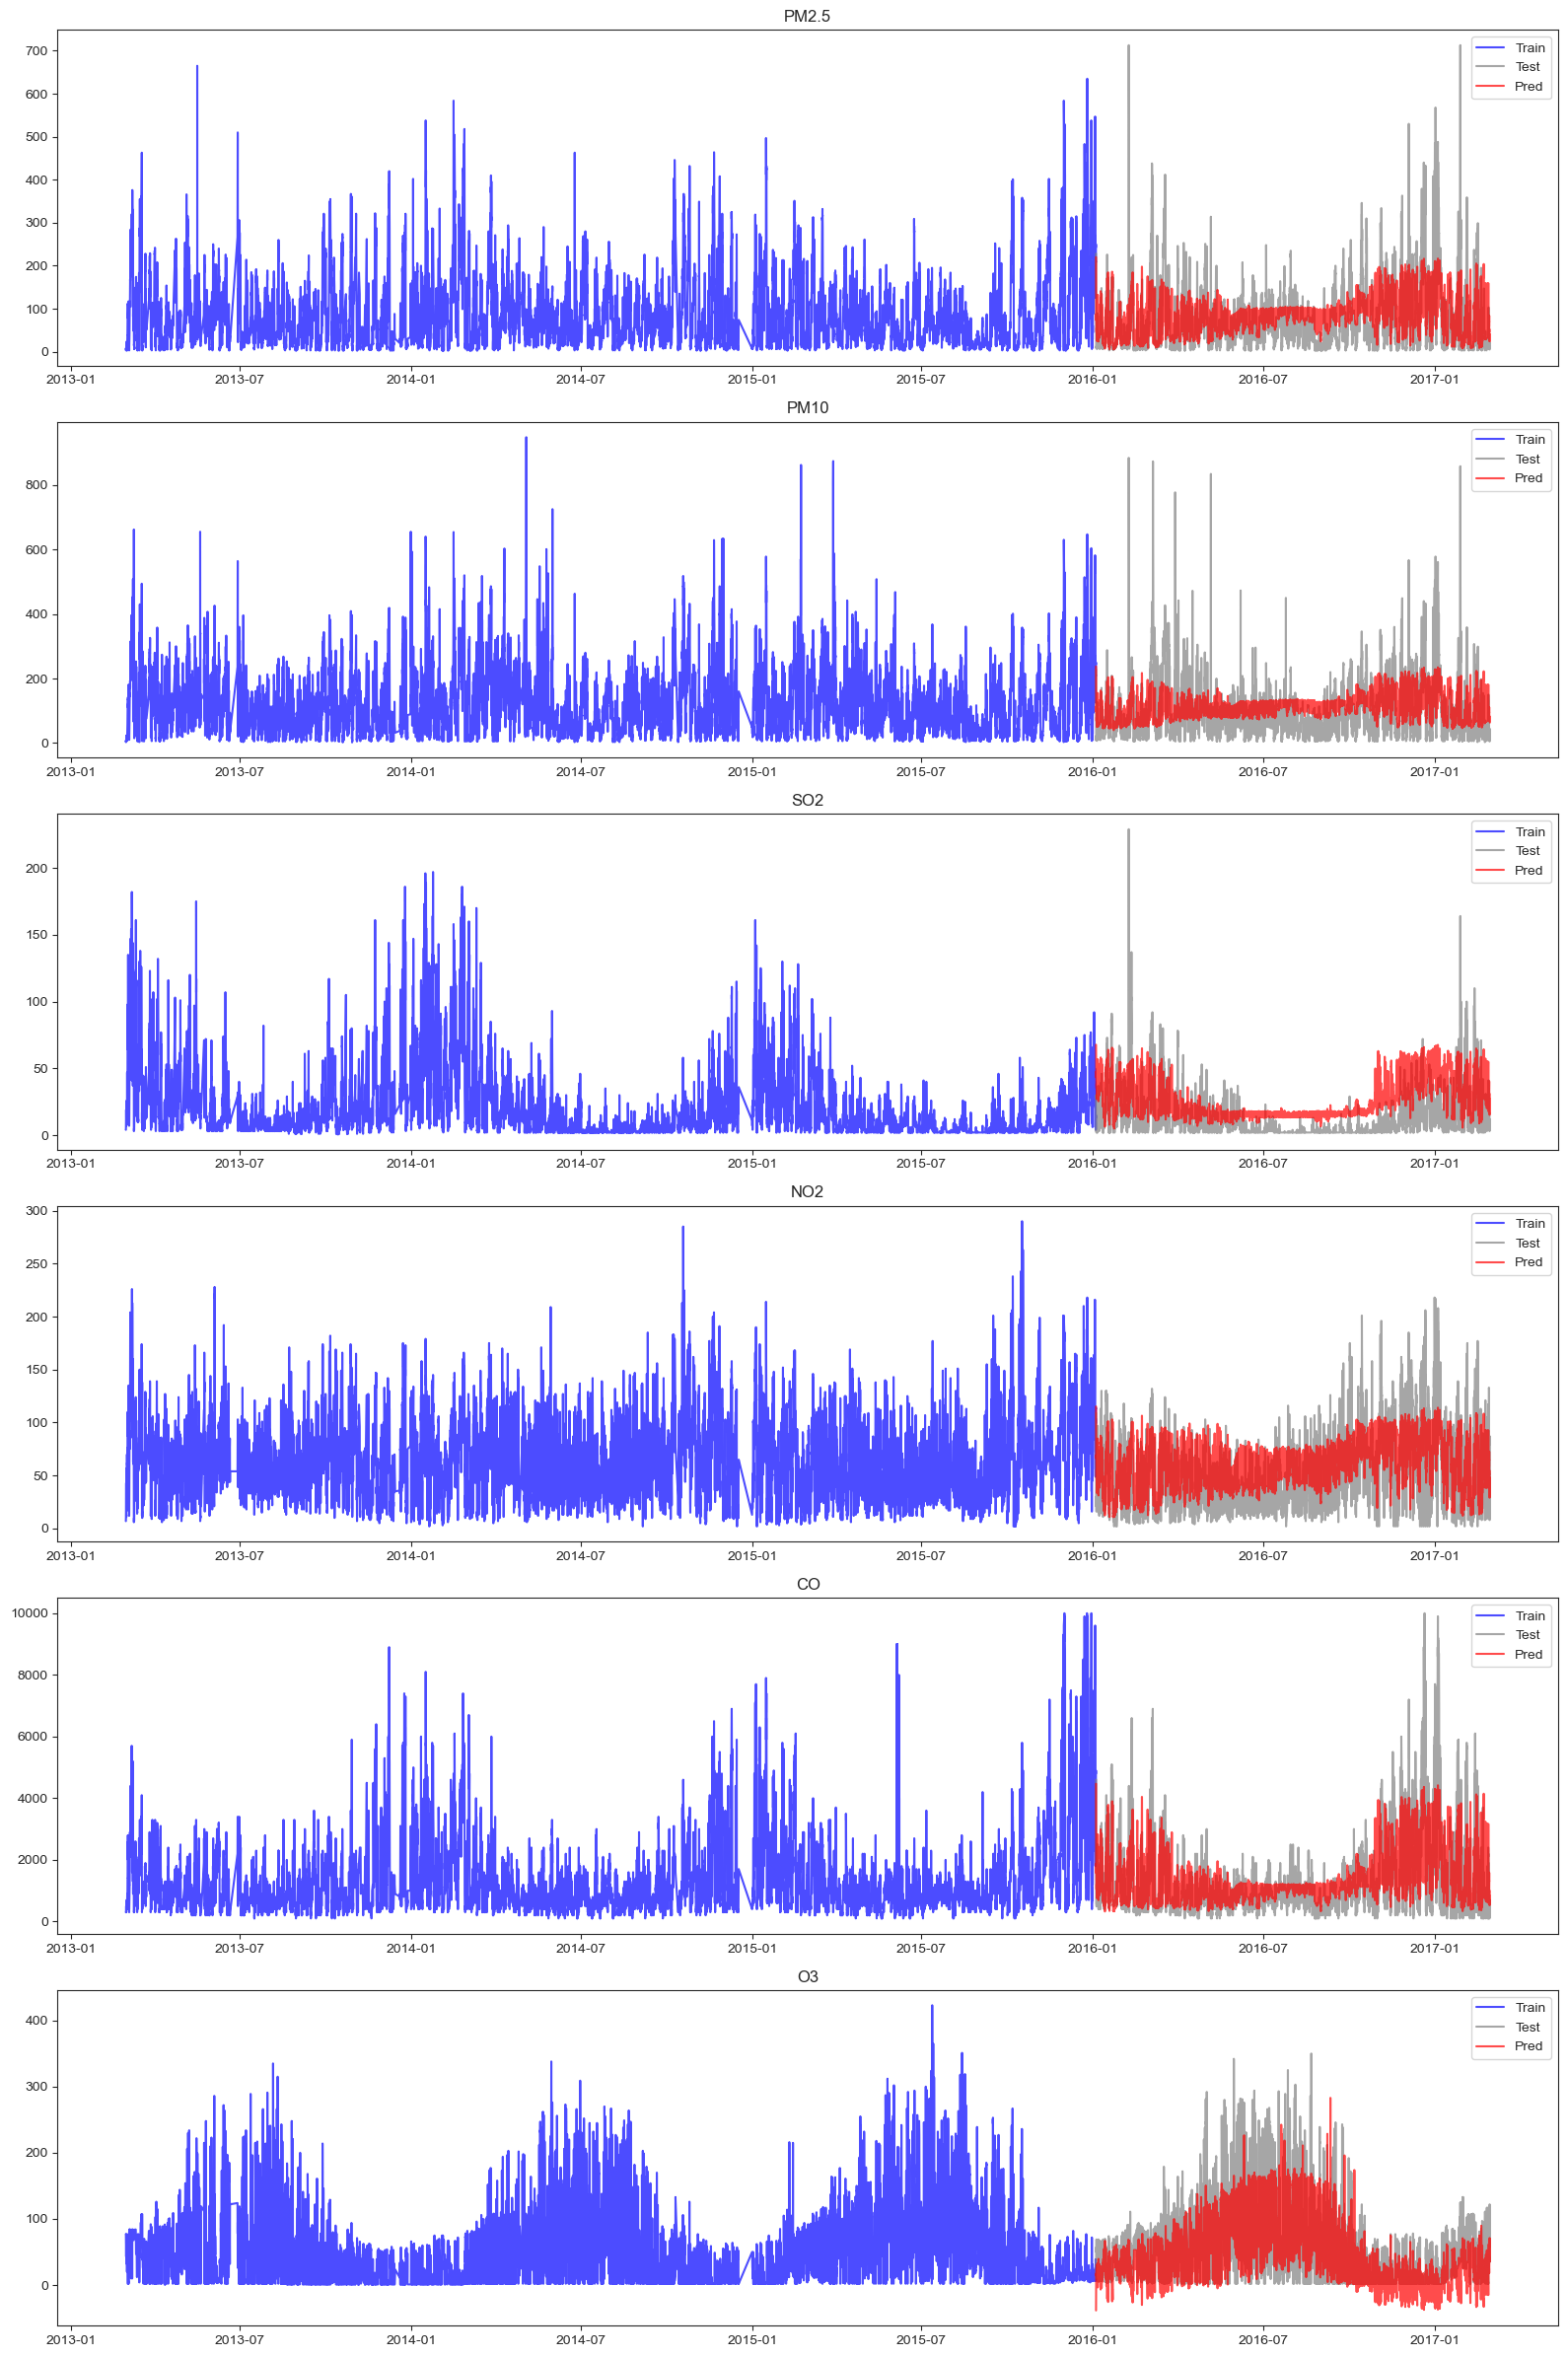

In [14]:
target_cols = ['PM2.5','PM10', 'SO2','NO2','CO','O3']
mae_list, mse_list, rmse_list = [],[],[]

fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(16, 24))

for i in range(0,6):
    ax[i].plot(y_train.index, y_train[target_cols[i]], label='Train',color='blue', alpha=0.7)
    ax[i].plot(y_test.index, y_test[target_cols[i]], label='Test', color='grey', alpha=0.7)
    ax[i].plot(y_test.index, preds[:,i], alpha=0.7, label='Pred', color='red')

    mae = mean_absolute_error(y_test[target_cols[i]], preds[:,i])
    mse = mean_squared_error(y_test[target_cols[i]], preds[:,i])
    rmse = np.sqrt(mse)
    
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    
    ax[i].set_title(f"{target_cols[i]}")
    ax[i].legend()

plt.tight_layout()
plt.show()

In [15]:
for i in range(len(target_cols)):
    print(f"{target_cols[i]}: MAE={mae_list[i]}, MSE={mse_list[i]}, RMSE={rmse_list[i]}")

PM2.5: MAE=48.31683042839554, MSE=4601.251395789527, RMSE=67.83252461606841
PM10: MAE=60.77761749806356, MSE=6628.3401340160035, RMSE=81.41461867512494
SO2: MAE=17.742106581457247, MSE=461.70138101468183, RMSE=21.48723763108422
NO2: MAE=23.570799423831396, MSE=827.8679725823599, RMSE=28.77269491344806
CO: MAE=642.2881027610036, MSE=881139.9588655528, RMSE=938.6905554364297
O3: MAE=28.712956481787415, MSE=1471.8690895072386, RMSE=38.364946103275564


### Vector Auto Regressor (VAR)

In [16]:
data = df_0.copy()
data.dropna(inplace=True)

In [17]:
train_size = int(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]

In [18]:
model = VAR(train_data)

sorted_order=model.select_order(maxlags=11)

print(sorted_order.summary())

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        60.33       60.33   1.589e+26       60.33
1        37.67       37.71   2.280e+16       37.68
2        36.94       37.03   1.103e+16       36.97
3        36.85       36.99   1.011e+16       36.90
4        36.80      36.98*   9.625e+15       36.86
5        36.77       36.99   9.336e+15       36.84
6        36.76       37.02   9.195e+15       36.84
7        36.74       37.05   9.046e+15       36.84
8        36.72       37.07   8.864e+15       36.84
9        36.71       37.10   8.742e+15       36.84
10       36.69       37.13   8.596e+15       36.83
11      36.67*       37.15  8.399e+15*      36.82*
--------------------------------------------------


In [19]:
lag = 26
results = model.fit(lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, May, 2024
Time:                     12:26:27
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    37.6173
Nobs:                     22287.0    HQIC:                   36.8518
Log likelihood:          -751248.    FPE:                6.98441e+15
AIC:                      36.4824    Det(Omega_mle):     6.06741e+15
--------------------------------------------------------------------
Results for equation PM2.5
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            20.021204        31.637146            0.633           0.527
L1.PM2.5          0.769396         0.009316           82.590           0.000
L1.PM10           0.084020         0.005210           16.127           0.000

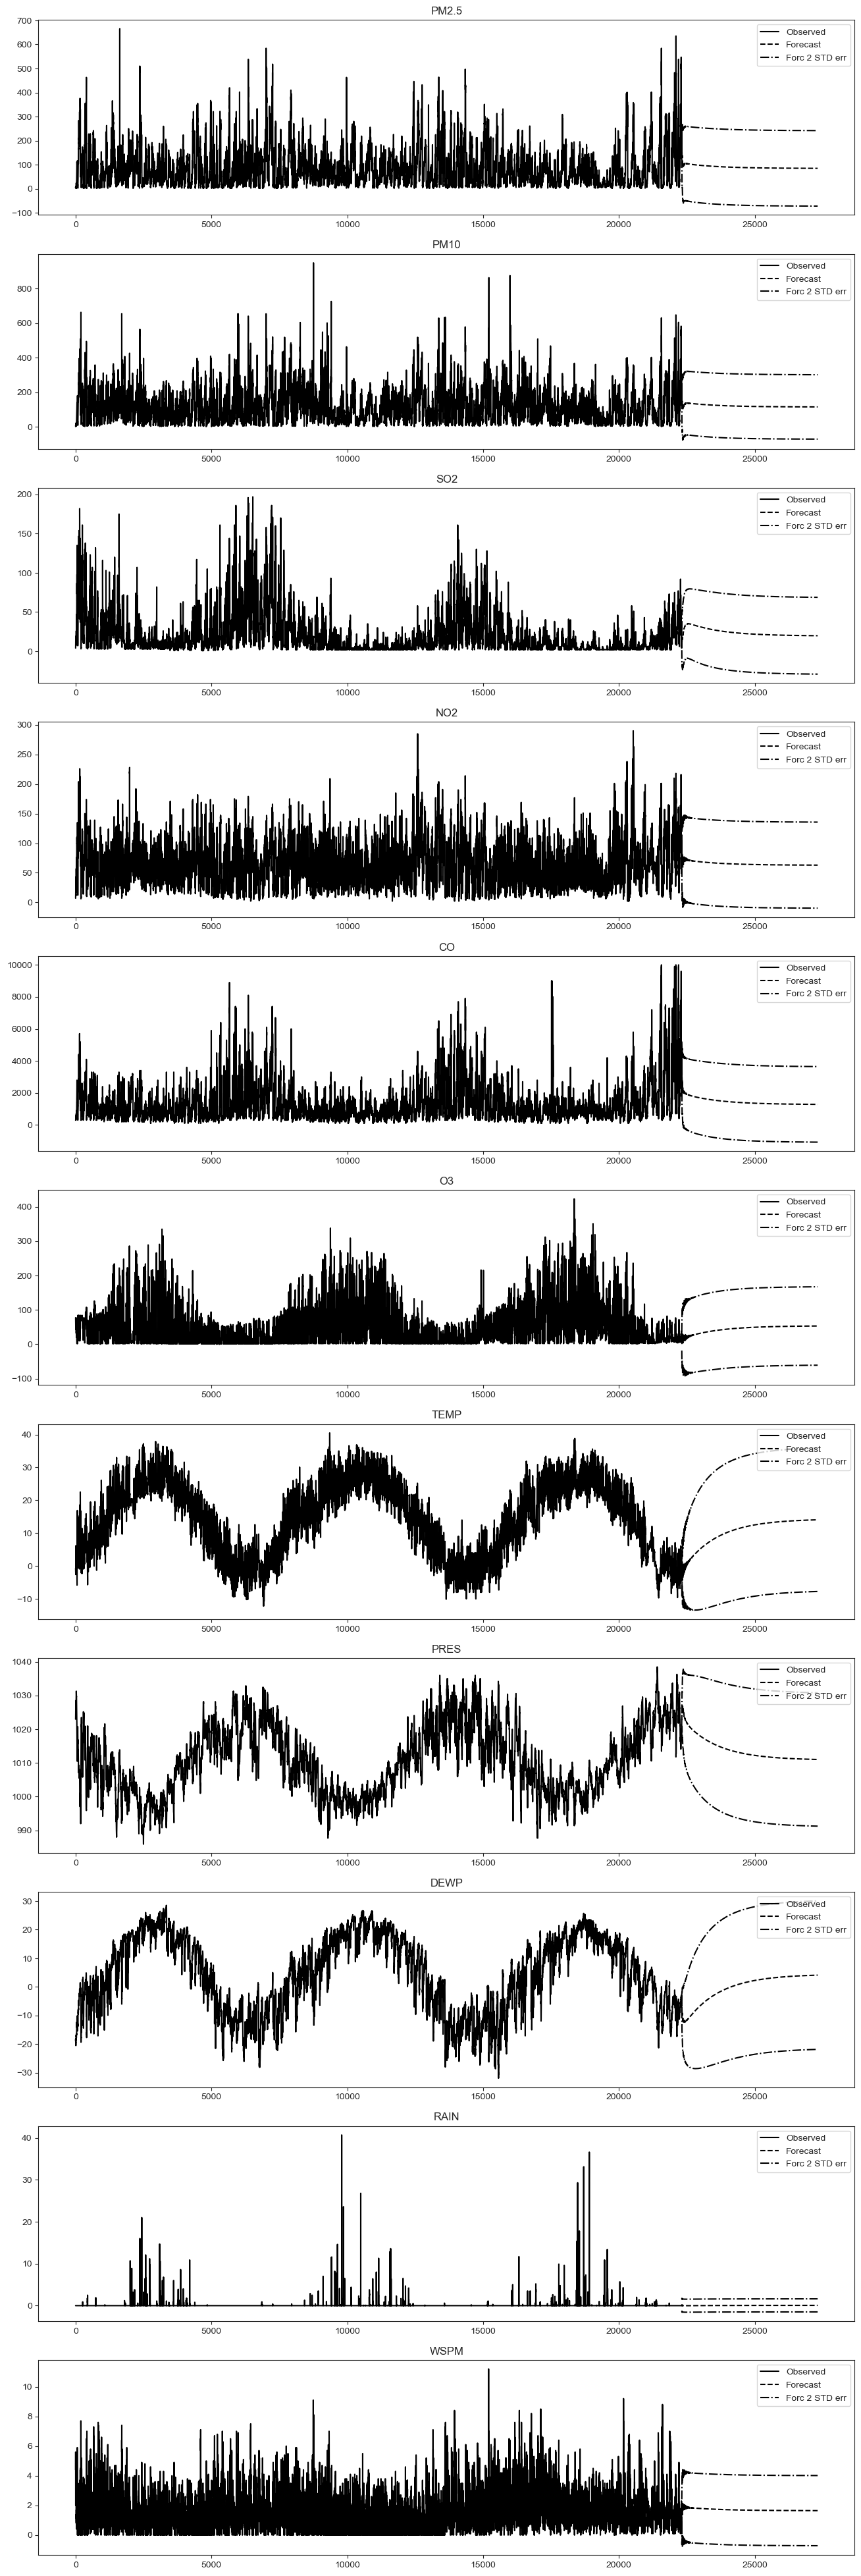

In [20]:
fig = results.plot_forecast(5000)
fig.set_size_inches(16, 50)
plt.show()

In [22]:
# Fit the VAR model
model = VAR(train_data)
lag = 26
results = model.fit(lag)

# Predict future values
predictions = results.forecast(test_data.values, steps=len(test_data))
predictions = pd.DataFrame(predictions)
print(test_data.mean(), predictions.mean(axis=0))
print(test_data[:])

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


PM2.5      75.749869
PM10       95.107393
SO2        12.038063
NO2        50.603890
CO       1240.604413
O3         60.659312
TEMP       12.115090
PRES     1014.325805
DEWP        0.124835
RAIN        0.072530
WSPM        1.891237
dtype: float64 0       85.893053
1      116.899984
2       20.570018
3       63.288395
4     1311.056010
5       52.119565
6       13.507523
7     1011.450205
8        3.387714
9        0.060472
10       1.659494
dtype: float64
                     PM2.5   PM10   SO2    NO2      CO    O3  TEMP    PRES  \
timestamp                                                                    
2016-01-04 02:00:00  228.0  228.0  28.0  109.0  4600.0  10.0  -4.3  1023.6   
2016-01-04 03:00:00  108.0  108.0  30.0   81.0  1800.0  13.0   0.1  1024.3   
2016-01-04 05:00:00    8.0    8.0   7.0   21.0   600.0  57.0  -0.8  1024.8   
2016-01-04 06:00:00    9.0    9.0   6.0   24.0   600.0  56.0  -1.4  1025.3   
2016-01-04 07:00:00   11.0   15.0   6.0   26.0   600.0  55.0  -1.7  1026.

In [23]:
lagged_Values = train_data.values[-lag:]
pred = results.forecast(y=lagged_Values, steps=100) 

idx = pd.date_range('2015-01-01', periods=100, freq='h')
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'])